In [1]:
import os
import shutil
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from numpy import deg2rad
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.stats import pearsonr


In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # List all keys
        keys = list(f.keys())
        #print(f"Keys: {keys}")

        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        light1 = sdata['light1']
        ppox = np.array(light1['pox'])
        ppoy = np.array(light1['poy'])
        pot = np.array(light1['pot'])
        poh = np.array(light1['poh'])
        pov = np.array(light1['pov'])
        f0 = np.array(light1['F0'])
        sintcptFreqy = np.array(light1['sintcptFreqy'])

        # Extract all cells containing the name 'R222'
        cell_names = [key for key in sdata.keys() if ratname in key]
        #print(f"Cell Names: {cell_names}")

        # Initialize dictionary to store data for all cells
        cells_data = {}

        # Iterate over each cell name and extract data
        for cell_name in cell_names:
            part_now = 'light1'  # Assuming 'light1' is the part_now equivalent

            pspx = np.array(sdata[cell_name][part_now]['spx'])
            pspy = np.array(sdata[cell_name][part_now]['spy'])
            pspt = np.array(sdata[cell_name][part_now]['spt'])
            pspv = np.array(sdata[cell_name][part_now]['spv'])
            psph = np.array(sdata[cell_name][part_now]['sph'])
            pspm = np.array(sdata[cell_name][part_now]['spm'])
            pval = np.array(sdata[cell_name][part_now]['pval'])
            spike_phase = np.array(sdata[cell_name][part_now]['spike_phase'])
            autocorrelogram = np.array(sdata[cell_name][part_now]['theta_train_long2'])
            hd_mean = np.array(sdata[cell_name][part_now]['hd_mean'])
            hd_std = np.array(sdata[cell_name][part_now]['hd_stdev'])
            tune_width = np.array(sdata[cell_name][part_now]['tuning_width'])
            intrinsic_freq = np.array(sdata[cell_name][part_now]['intrinsic_theta_frequency'])

            # Extract and decode cell_type
            cell_type_array = np.array(sdata[cell_name][part_now]['thetacell_type'])
            cell_type = ''.join([chr(ascii_val[0]) for ascii_val in cell_type_array])

            # Store the data for this cell
            cells_data[cell_name] = {
                'pspx': pspx,
                'pspy': pspy,
                'pspt': pspt,
                'pspv': pspv,
                'psph': psph,
                'pspm': pspm,
                'pval': pval,
                'spike_phase': spike_phase,
                'autocorrelogram': autocorrelogram,
                'hd_mean': hd_mean,
                'hd_std': hd_std,
                'tune_width': tune_width,
                'intrinsic_freq': intrinsic_freq,
                'cell_type': cell_type
            }

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'f0': f0,
            'sintcptFreqy': sintcptFreqy,
            'cell_names': cell_names,
            'cells_data': cells_data
        }

        return data_dict



In [3]:
def compute_spike_array(spike_times, timestamps):
    """
    Compute the spike array from spike times and timestamps.
    """
    
    # Assume t is sorted. If not, you must sort it first.
    indices = np.searchsorted(timestamps, spike_times, side='right')

    # Ensure no out-of-bounds indices
    indices = np.clip(indices, 0, len(timestamps) - 1)

    # Adjust indices to always refer to the nearest timestamp
    # If the index points to the start of the array, no need to adjust
    # If not, check if the previous index is closer
    prev_close = (indices > 0) & (np.abs(timestamps[indices - 1] - spike_times) < np.abs(timestamps[indices] - spike_times))
    indices[prev_close] -= 1

    spike_array = np.zeros_like(timestamps)
    np.add.at(spike_array, indices, 1) #very fast!
    
    return spike_array

def compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5):
    # Number of bins for the max_lag
    max_lag_bins = int(max_lag / bin_size)
    autocorr = np.correlate(spike_array, spike_array, mode='full')
    mid_point = len(autocorr) // 2
    autocorr = autocorr[mid_point - max_lag_bins: mid_point + max_lag_bins + 1]
    
    # Normalize the autocorrelation values
    lags = np.arange(-max_lag_bins, max_lag_bins + 1) * bin_size  # Lags in seconds
    
    idx_range = np.where((lags >= 0.05) & (lags <= 0.25))[0]
    max_value = np.max(autocorr[idx_range])
    autocorr = autocorr / max_value
    autocorr = np.clip(autocorr, a_min=None, a_max=1)  # Clip values above 1
    
    lags_ms = lags * 1000  # Convert to ms
    
    # Convert autocorr, lags into a 2*n array
    return np.array([autocorr, lags_ms])
    
def is_outside_range(angle, center, range_):
    angle = angle % (2 * np.pi)
    center = center % (2 * np.pi)
    lower_bound = (center - range_) % (2 * np.pi)
    upper_bound = (center + range_) % (2 * np.pi)
    
    if lower_bound < upper_bound:
        return not (lower_bound <= angle <= upper_bound)
    else:
        return not (angle >= lower_bound or angle <= upper_bound)    
    
def get_autocorrelogram_align_and_misalign(hd_mean, angle, pot_interp, pspt, psph, bin_size):
    
    '''
    get autocorrelogram when the head direction align with the hd_mean +- angle range, and when it is not
    return autocorrelogram_align, autocorrelogram_misalign
    '''
    
    #find all psph that are not in the range of hd_mean +- angle, then save pspt to pspt_offset,
    # be careful with the jump between 0 and 2pi
    pspt_offset = []
    for i in range(len(psph)):
        #degree to radian
        a = np.deg2rad(psph[i])
        b = np.deg2rad(hd_mean)
        c = np.deg2rad(angle)
        #if a located out of the range of b +- c on the circle, then keep it
        if is_outside_range(a, b, c):
            pspt_offset.append(pspt[i])

    spike_array = compute_spike_array(pspt_offset, pot_interp)
    autocorrelogram_misalign = compute_autocorrelation(spike_array, bin_size=bin_size, max_lag=0.5) 

    #get remaining spike time
    pspt_rest = np.setdiff1d(pspt, pspt_offset)
    spike_array = compute_spike_array(pspt_rest, pot_interp)
    autocorrelogram_align = compute_autocorrelation(spike_array, bin_size=bin_size, max_lag=0.5)

    return autocorrelogram_misalign, autocorrelogram_align    

def get_autocorrelogram_anglebins(hd_mean, angle, anglebins, pot_interp, pspt, psph, bin_size):
    
    '''
    get autocorrelogram when the head direction align with the hd_mean +- angle range, and when it is not
    return autocorrelogram_align, autocorrelogram_misalign
    '''
    autocorrelogram = {}
    
    #find all psph that are not in the range of hd_mean +- angle, then save pspt to pspt_offset,
    # be careful with the jump between 0 and 2pi
    b = np.deg2rad(hd_mean)
    c = np.deg2rad(angle)
    pspt_offset = {j: [] for j in range(anglebins)}
    psph_offset = {j: [] for j in range(anglebins)}
    
    for i in range(len(psph)):
        #degree to radian
        a = np.deg2rad(psph[i])

    
        for j in range(anglebins):
            cj_1 = c * j + 1e-10
            cj_2 = c * (j + 1)
            #if the value a is is_outside_range(a, b, anglebcj_1) and not is_outside_range(a, b, anglebcj_2), then keep it
            if is_outside_range(a, b, cj_1) and not is_outside_range(a, b, cj_2):
                pspt_offset[j].append(pspt[i])
                psph_offset[j].append(psph[i])

    for j in range(anglebins):
        spike_array = compute_spike_array(pspt_offset[j], pot_interp)
        autocorrelogram[j] = compute_autocorrelation(spike_array, bin_size=bin_size, max_lag=0.5) 

    # #scatter plot psph_offset with differnt colotrs in each group
    # plt.figure()
    # for j in range(anglebins):
    #     plt.scatter(psph_offset[j], np.ones(len(psph_offset[j])), s=5)
    # plt.show()
    
    return autocorrelogram

def calculate_skipping_index(autocorrelogram):
    def model(t, a1, a2, b, c, omega, t1, t2):
        return (a1 * (np.cos(omega * t) + 1) + a2 * (np.cos(0.5 * omega * t) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2)

    # Fit the model to the autocorrelogram data
    initial_guess = [0.5, 0.5, 0.1, 0.1, 2 * np.pi * 8, 0.01, 0.01]  # Initial guesses for a1, a2, b, c, omega, t1, t2
    bounds = ([0, 0, 0, -1, 10 * np.pi, 0, 0], [1, 1, 1, 1, 18 * np.pi, 5., 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    lags = autocorrelogram[1, :] / 1000  # Convert lags to seconds

    params, covariance = curve_fit(model, lags, autocorr, p0=initial_guess, bounds=bounds)
    a1, a2, b, c, omega, t1, t2 = params

    # Calculate p1 and p2
    p1 = model(2 * np.pi / omega, *params)
    p2 = model(4 * np.pi / omega, *params)

    # Calculate the theta cycle skipping index
    TS = (p2 - p1) / max(p1, p2)
    
    print(f"Intrinsic Theta Frequency: {omega / (2 * np.pi):.2f} Hz")
    print(f"Theta Cycle Skipping Index: {TS:.2f}")
    
    return omega / (2 * np.pi), TS  # Return frequency in Hz and the TS index



In [4]:
def plot_head_direction_tuning(ax, ppoh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()

    return ax

def plot_autocorrelogram(ax, autocorrelogram, cell_type, labelsize=10, ticksize=8):
    
    ax.plot(autocorrelogram[1,:], autocorrelogram[0,:], 'k')
    #fillin between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorrelogram[0,:], facecolor='black', alpha=1)
    
    ax.set_xticks([-500, 0, 500])
    ax.set_xticklabels(['-0.5', '0', '0.5'])
    ax.set_yticks([])
    ax.set_xlabel('Lag (s)', fontsize=labelsize)
    ax.set_title(cell_type, fontsize=labelsize)
    #set tick fontsize for both x and y
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    #tickbar length=0
    ax.tick_params(axis='both', length=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    return ax

def plot_colored_wheel(ax, angles, color):
    # Create the main circle
    circle = plt.Circle((0, 0), 1, edgecolor='black', facecolor='none')
    ax.add_artist(circle)

    def color_region(start_angle, end_angle, color):
        wedge = patches.Wedge((0, 0), 1, start_angle, end_angle, facecolor=color, edgecolor='none', alpha=0.8)
        ax.add_artist(wedge)

    # Color from 90-angles[0] to 90-angles[1]
    color_region(90 - angles[1], 90 - angles[0], color)
    # Color from 90+angles[0] to 90+angles[1]
    color_region(90 + angles[0], 90 + angles[1], color)

    # Add an arrow pointing north
    ax.arrow(0, 0, 0, 0.9, head_width=0.1, head_length=0.1, fc='black', ec='black')
    
    # Set the limits and labels
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Add north label
    # ax.text(0, 1.1, 'Preferred\ndirection', ha='center', va='center', fontsize=12, weight='bold')

    ax.set_aspect('equal', adjustable='box')
    
    # Axis off
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    return ax


## autocorrelogram of align versus misalign run

In [5]:
base_dir = '/home/zilong/Desktop/GridCellThetaSweeps/LomiData/'
output_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/autocorr_allHDcells/'
output_skip_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/autocorr_thetaskipcells/'
output_nonskip_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/autocorr_thetanoskipcells/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'angle_range': 15, #degree
    'interpolation_factor': 2, #1 is 0.02s, and 2 is 0.01s
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

total_hd_cells = 0

correlogram_skipcells_align = []
correlogram_skipcells_misalign = []

correlogram_nonskipcells_align = []
correlogram_nonskipcells_misalign = []

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        cell_type = cell_data['cell_type']
                        
                        if pval < 0.05:  # select only head direction tuned cells
                            # plot
                            fig = plt.figure(figsize=(16, 4))
                            gs = fig.add_gridspec(1, 5)
                            
                            # plot head direction tuning map
                            ax0 = fig.add_subplot(gs[0, 0], projection='polar')
                            plot_head_direction_tuning(ax0, ppoh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config)
                            
                            # plot autocorrelogram, i.e., check theta modulation
                            ax1 = fig.add_subplot(gs[0, 1])
                            plot_autocorrelogram(ax1, autocorrelogram, cell_type)
                            
                            # plot spike phase versus head direction, i.e., check phase precession
                            ax2 = fig.add_subplot(gs[0, 2])
                            spike_array = compute_spike_array(pspt, pot_interp)
                            autocorrelogram2 = compute_autocorrelation(spike_array, bin_size=new_interval, max_lag=0.5)
                            plot_autocorrelogram(ax2, autocorrelogram2, cell_type)
                            
                            angle = config['angle_range']
                            autocorrelogram_misalign, autocorrelogram_align = get_autocorrelogram_align_and_misalign(hd_mean, angle, pot_interp, pspt, psph, bin_size=new_interval)
                            ax3 = fig.add_subplot(gs[0, 3])
                            plot_autocorrelogram(ax3, autocorrelogram_misalign, cell_type)
                            
                            ax4 = fig.add_subplot(gs[0, 4])
                            plot_autocorrelogram(ax4, autocorrelogram_align, cell_type)
                            
                            output_path = os.path.join(output_dir, f"{cell_name}.png")
                            plt.tight_layout()
                            plt.savefig(output_path)
                            
                            # save fig according to cell type in different folders
                            if 'ThetaxHD' in cell_type:
                                if 'skip' in cell_type:
                                    output_skip_path = os.path.join(output_skip_dir, f"{cell_name}.png")
                                    plt.savefig(output_skip_path)
                                    correlogram_skipcells_align.append(autocorrelogram_align)
                                    correlogram_skipcells_misalign.append(autocorrelogram_misalign)
                                elif 'Strong ThetaxHD' in cell_type:
                                    output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}.png")
                                    plt.savefig(output_nonskip_path)
                                    correlogram_nonskipcells_align.append(autocorrelogram_align)
                                    correlogram_nonskipcells_misalign.append(autocorrelogram_misalign)
                                
                            plt.close(fig)
                            
                            total_hd_cells += 1
                        
print(f"Total number of HD cells processed: {total_hd_cells}")

Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_090819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_230819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_200819_T1_sdata.mat
Processing /home/z

/tmp/ipykernel_3808106/540524818.py:35: RuntimeWarning: invalid value encountered in divide
  autocorr = autocorr / max_value
/tmp/ipykernel_3808106/540524818.py:35: RuntimeWarning: invalid value encountered in divide
  autocorr = autocorr / max_value


Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_130819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_280819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_050919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_120919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_190919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_060919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_210819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_190819_T1_sdata.mat
Processing /home/zilong/Deskt

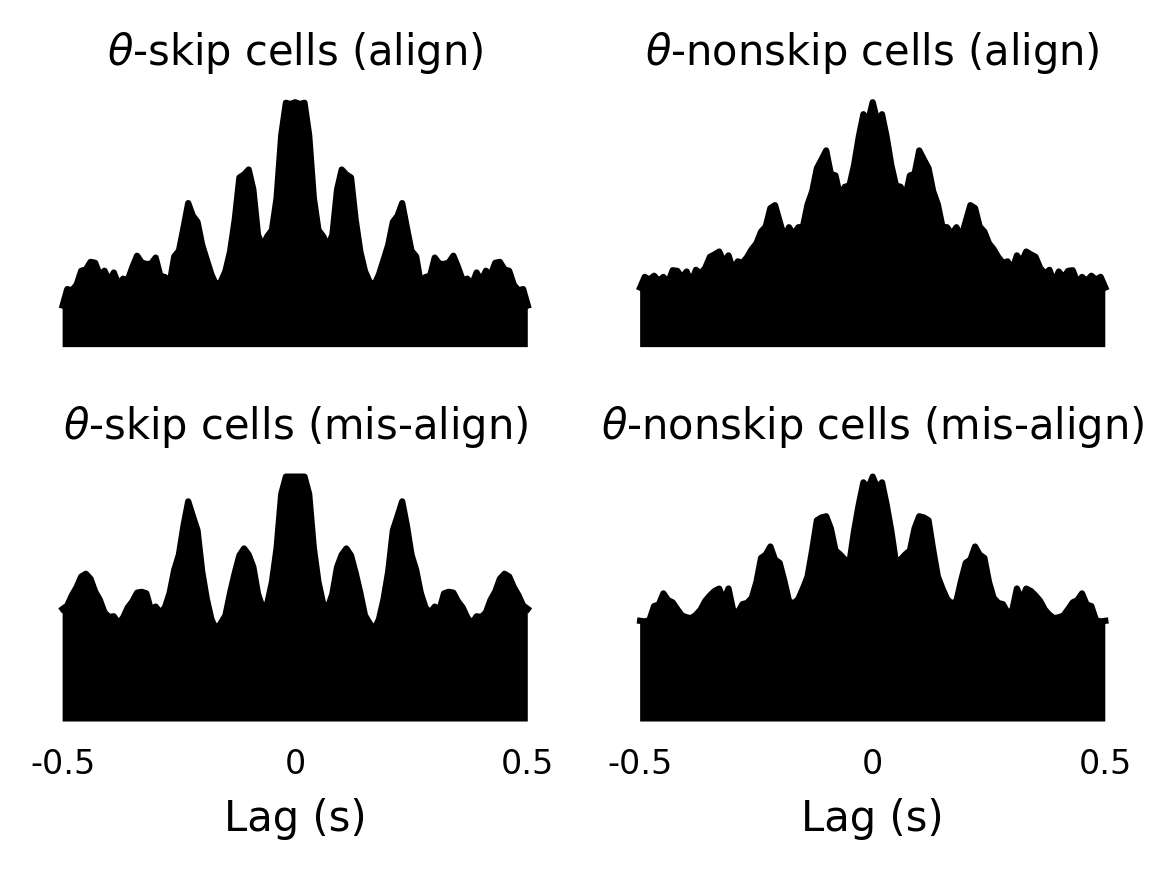

In [6]:
#plot the averaged autocorrelogram for correlogram_skipcells_align, correlogram_skipcells_misalign, correlogram_nonskipcells_align, correlogram_nonskipcells_misalign
#in a 2*2 grid plot

fig = plt.figure(figsize=(4,3), dpi=300)
num_skip_cells = len(correlogram_skipcells_align)
num_nonskip_cells = len(correlogram_nonskipcells_align)

labelsize = 10
fontsize = 8
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, 0])
skip_align_avg = np.mean(np.array(correlogram_skipcells_align), axis=0)
plot_autocorrelogram(ax0, skip_align_avg, cell_type=r'$\theta$-skip cells (align)', labelsize=labelsize, ticksize=fontsize)
ax0.set_xlabel('')
ax0.set_xticks([])

ax1 = fig.add_subplot(gs[1, 0])
skip_misalign_avg = np.mean(np.array(correlogram_skipcells_misalign), axis=0)
plot_autocorrelogram(ax1, skip_misalign_avg, cell_type=r'$\theta$-skip cells (mis-align)', labelsize=labelsize, ticksize=fontsize)

ax2 = fig.add_subplot(gs[0, 1])
nonskip_align_avg = np.mean(np.array(correlogram_nonskipcells_align), axis=0)
plot_autocorrelogram(ax2, nonskip_align_avg, cell_type=r'$\theta$-nonskip cells (align)', labelsize=labelsize, ticksize=fontsize)
ax2.set_xlabel('')
ax2.set_xticks([])

ax3 = fig.add_subplot(gs[1, 1])
nonskip_misalign_avg = np.mean(np.array(correlogram_nonskipcells_misalign), axis=0)
plot_autocorrelogram(ax3, nonskip_misalign_avg, cell_type=r'$\theta$-nonskip cells (mis-align)', labelsize=labelsize, ticksize=fontsize)

plt.tight_layout()

plt.savefig('./figures/autocorr_align_vs_misalign.pdf')



# autocorrelagram of misalign bins 

In [7]:
base_dir = '/home/zilong/Desktop/GridCellThetaSweeps/LomiData/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'angle_range': 20, #degree
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'anglebins': 4
}

total_hd_cells = 0

correlogram_skipcells_bins = []
correlogram_nonskipcells_bins= []
correlogram_thetacells_bins = []
tune_width_theta_cells = []

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        cell_type = cell_data['cell_type']
                        
                        if pval < 0.05:  # select only head direction tuned cells
                            
                            angle = config['angle_range']
                            anglebins = config['anglebins']
                            # angle = hd_std / anglebins
                            # save fig according to cell type in different folders
                            if 'ThetaxHD' in cell_type:
                                autocorrelograms = get_autocorrelogram_anglebins(hd_mean, angle, anglebins, pot_interp, pspt, psph, bin_size=new_interval)
                                tune_width_theta_cells.append(tune_width)
                                correlogram_thetacells_bins.append(autocorrelograms)
                                if 'skip' in cell_type:
                                    correlogram_skipcells_bins.append(autocorrelograms)
                                elif 'Strong ThetaxHD' in cell_type:
                                    correlogram_nonskipcells_bins.append(autocorrelograms)
                            
                            total_hd_cells += 1
                        
print(f"Total number of HD cells processed: {total_hd_cells}")

Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_090819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_230819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_200819_T1_sdata.mat
Processing /home/z

/tmp/ipykernel_3808106/540524818.py:35: RuntimeWarning: invalid value encountered in divide
  autocorr = autocorr / max_value
/tmp/ipykernel_3808106/540524818.py:35: RuntimeWarning: divide by zero encountered in divide
  autocorr = autocorr / max_value


Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_130819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_280819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_050919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_120919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_190919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_060919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_210819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_190819_T1_sdata.mat
Processing /home/zilong/Deskt

### get theta skipping index for skipping cells

Intrinsic Theta Frequency: 9.00 Hz
Theta Cycle Skipping Index: -0.05
Intrinsic Theta Frequency: 9.00 Hz
Theta Cycle Skipping Index: -0.48
Intrinsic Theta Frequency: 7.04 Hz
Theta Cycle Skipping Index: -0.04
Intrinsic Theta Frequency: 9.00 Hz
Theta Cycle Skipping Index: 0.03
Intrinsic Theta Frequency: 8.81 Hz
Theta Cycle Skipping Index: -0.27
Intrinsic Theta Frequency: 9.00 Hz
Theta Cycle Skipping Index: -0.20
Intrinsic Theta Frequency: 8.92 Hz
Theta Cycle Skipping Index: -0.28
Intrinsic Theta Frequency: 8.83 Hz
Theta Cycle Skipping Index: -0.31
Intrinsic Theta Frequency: 9.00 Hz
Theta Cycle Skipping Index: -0.20
Intrinsic Theta Frequency: 5.13 Hz
Theta Cycle Skipping Index: -0.18
Intrinsic Theta Frequency: 8.70 Hz
Theta Cycle Skipping Index: 0.33
Intrinsic Theta Frequency: 5.16 Hz
Theta Cycle Skipping Index: 0.14
Intrinsic Theta Frequency: 9.00 Hz
Theta Cycle Skipping Index: -0.13
Intrinsic Theta Frequency: 8.36 Hz
Theta Cycle Skipping Index: 0.40
Intrinsic Theta Frequency: 8.26 Hz
The

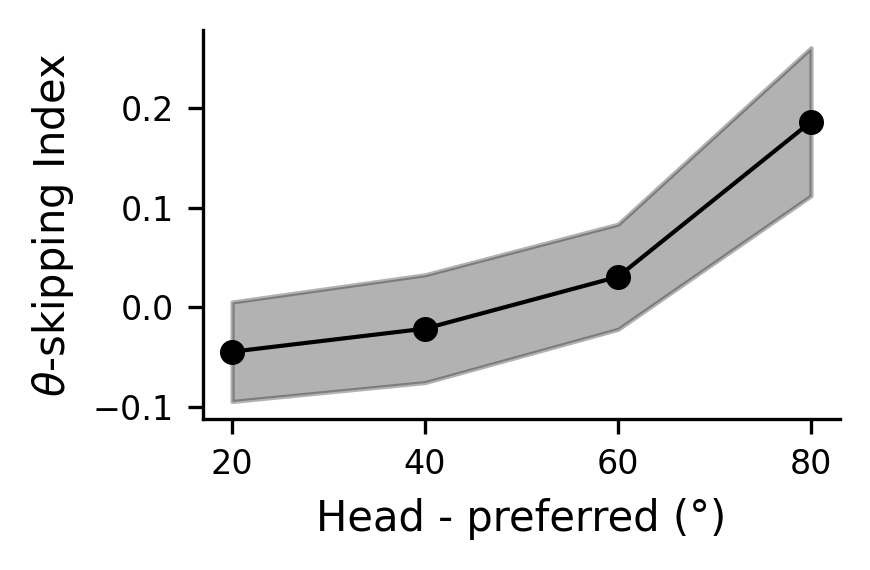

In [8]:
#calculate the theta skipping index for each cell each angle bin
all_TS = np.zeros((len(correlogram_skipcells_bins), config['anglebins']))

for i in range(len(correlogram_skipcells_bins)):
    cell_autocorrelograms_bins = correlogram_skipcells_bins[i]
    # dict to array
    cell_autocorrelograms_bins = np.array([cell_autocorrelograms_bins[j] for j in range(config['anglebins'])])
    for j in range(config['anglebins']):
        autocorrelogram = cell_autocorrelograms_bins[j]
        try:
            all_TS[i, j] = calculate_skipping_index(autocorrelogram)[1]
        except:
            all_TS[i, j] = np.nan

#plot the TS for each angle bin with fill between of standard error of the mean
mean_TS_skip = np.nanmean(all_TS, axis=0)
sem_TS_skip = np.nanstd(all_TS, axis=0) / np.sqrt(len(correlogram_skipcells_bins))

fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
labelsize = 10
ticksize = 8

angle = config['angle_range']
anglebins = config['anglebins']
x = np.arange(angle, (anglebins+1)*angle, angle)
ax.plot(x, mean_TS_skip, color='black', marker='o', markersize=5, linewidth=1)

ax.fill_between(x, mean_TS_skip - sem_TS_skip, mean_TS_skip + sem_TS_skip, color='black', alpha=0.3)

ax.set_xlabel('Head - preferred (°)', fontsize=labelsize)
ax.set_ylabel(r'$\theta$-skipping Index', fontsize=labelsize)
ax.tick_params(axis='both', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/theta_skipping_index.pdf')

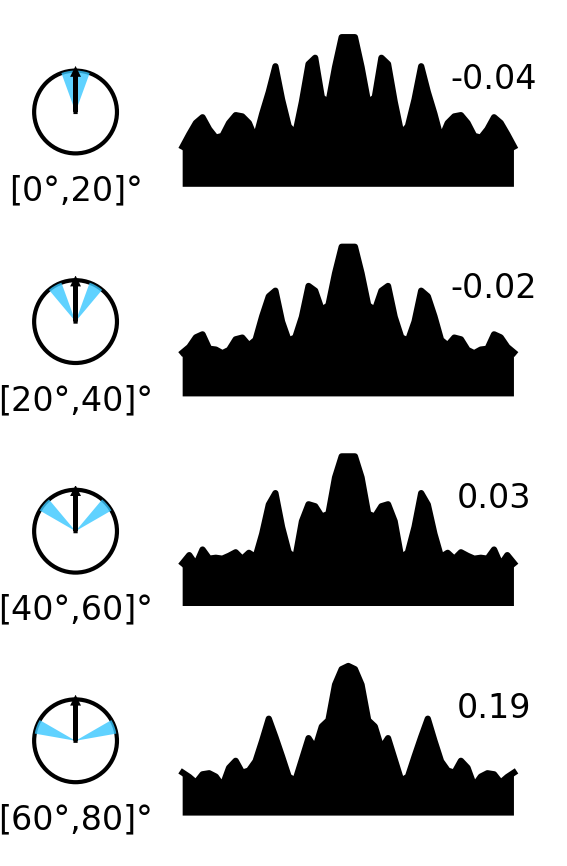

In [9]:
all_autocorrelograms = []
for i in range(len(correlogram_skipcells_bins)):
    cell_autocorrelograms_bins = correlogram_skipcells_bins[i]
    # dict to array
    cell_autocorrelograms_bins = np.array([cell_autocorrelograms_bins[j] for j in range(config['anglebins'])])
    all_autocorrelograms.append(cell_autocorrelograms_bins)
#to array
all_autocorrelograms = np.array(all_autocorrelograms)
#mena over the first axis
mean_autocorrelograms = np.nanmean(all_autocorrelograms, axis=0)

#plot in a 5*1 grid
fig = plt.figure(figsize=(2, 3), dpi=300)

labelsize = 10
ticksize = 8
gs = fig.add_gridspec(config['anglebins'], 2, width_ratios=[1, 4])



angle = config['angle_range']
for i in range(config['anglebins']):
    ax = fig.add_subplot(gs[i, 1])
    plot_autocorrelogram(ax, mean_autocorrelograms[i], cell_type=f'offset angle {(i+1)*angle}°', labelsize=labelsize, ticksize=ticksize)
    ax.set_title('')
    #add text as f'offset angle {(i+1)*angle}°'
    ax.text(0.9, 0.7, f'{mean_TS_skip[i]:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=ticksize)
    if i < config['anglebins'] - 0:
        ax.set_xticks([])
        ax.set_xlabel('')
    # ax.set_xlabel(r'$\theta$-skipping index' + f'{mean_TS[i]:.2f}', fontsize=labelsize)

for i in range(config['anglebins']):
    ax = fig.add_subplot(gs[i, 0])
    plot_colored_wheel(ax, [angle * i, angle * (i + 1)], color='#38c7ff')
    ax.set_xlabel(f'[{i*angle}°,{(i+1)*angle}]°', fontsize=ticksize)
    
plt.tight_layout()

plt.savefig('./figures/theta_skipping_different_anglebins.pdf')


### get theta skipping index for non-skipping cells

Intrinsic Theta Frequency: 8.90 Hz
Theta Cycle Skipping Index: -0.19
Intrinsic Theta Frequency: 5.41 Hz
Theta Cycle Skipping Index: -0.52
Intrinsic Theta Frequency: 5.88 Hz
Theta Cycle Skipping Index: -0.44
Intrinsic Theta Frequency: 8.44 Hz
Theta Cycle Skipping Index: -1.00
Intrinsic Theta Frequency: 5.00 Hz
Theta Cycle Skipping Index: -0.21
Intrinsic Theta Frequency: 5.00 Hz
Theta Cycle Skipping Index: -0.35
Intrinsic Theta Frequency: 5.00 Hz
Theta Cycle Skipping Index: -0.62
Intrinsic Theta Frequency: 5.89 Hz
Theta Cycle Skipping Index: 0.01
Intrinsic Theta Frequency: 8.60 Hz
Theta Cycle Skipping Index: -0.14
Intrinsic Theta Frequency: 5.00 Hz
Theta Cycle Skipping Index: -0.27
Intrinsic Theta Frequency: 5.27 Hz
Theta Cycle Skipping Index: 0.21
Intrinsic Theta Frequency: 7.91 Hz
Theta Cycle Skipping Index: -0.63
Intrinsic Theta Frequency: 5.03 Hz
Theta Cycle Skipping Index: -0.03
Intrinsic Theta Frequency: 9.00 Hz
Theta Cycle Skipping Index: -0.25
Intrinsic Theta Frequency: 5.00 Hz
T

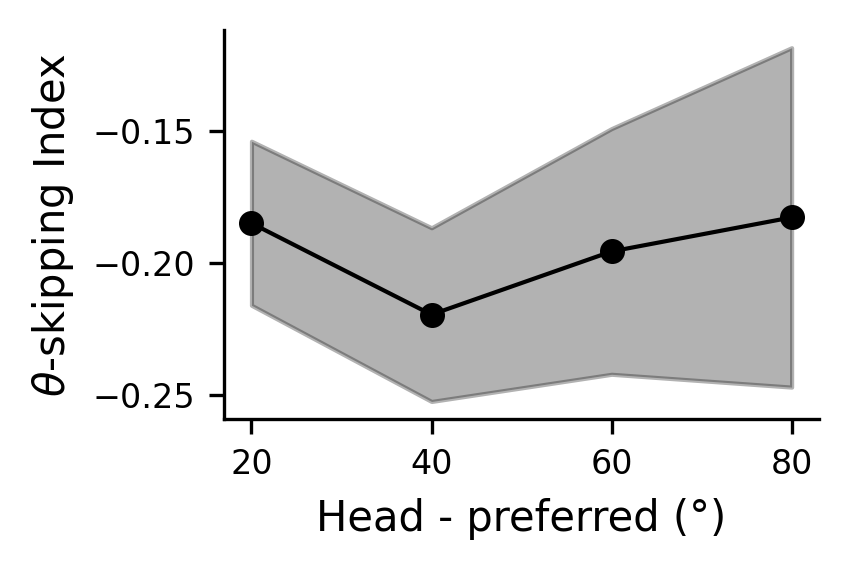

In [10]:
#calculate the theta skipping index for each cell each angle bin
all_TS = np.zeros((len(correlogram_nonskipcells_bins), config['anglebins']))

for i in range(len(correlogram_nonskipcells_bins)):
    cell_autocorrelograms_bins = correlogram_nonskipcells_bins[i]
    # dict to array
    cell_autocorrelograms_bins = np.array([cell_autocorrelograms_bins[j] for j in range(config['anglebins'])])
    for j in range(config['anglebins']):
        autocorrelogram = cell_autocorrelograms_bins[j]
        try:
            all_TS[i, j] = calculate_skipping_index(autocorrelogram)[1]
        except:
            all_TS[i, j] = np.nan
            
#plot the TS for each angle bin with fill between of standard error of the mean
mean_TS_noskip = np.nanmean(all_TS, axis=0)
sem_TS_noskip = np.nanstd(all_TS, axis=0) / np.sqrt(len(correlogram_nonskipcells_bins))

fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
labelsize = 10
ticksize = 8

angle = config['angle_range']
anglebins = config['anglebins']
x = np.arange(angle, (anglebins+1)*angle, angle)
ax.plot(x, mean_TS_noskip, color='black', marker='o', markersize=5, linewidth=1)

ax.fill_between(x, mean_TS_noskip - sem_TS_noskip, mean_TS_noskip + sem_TS_noskip, color='black', alpha=0.3)

ax.set_xlabel('Head - preferred (°)', fontsize=labelsize)
ax.set_ylabel(r'$\theta$-skipping Index', fontsize=labelsize)
ax.tick_params(axis='both', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/theta_nonskipping_index.pdf')

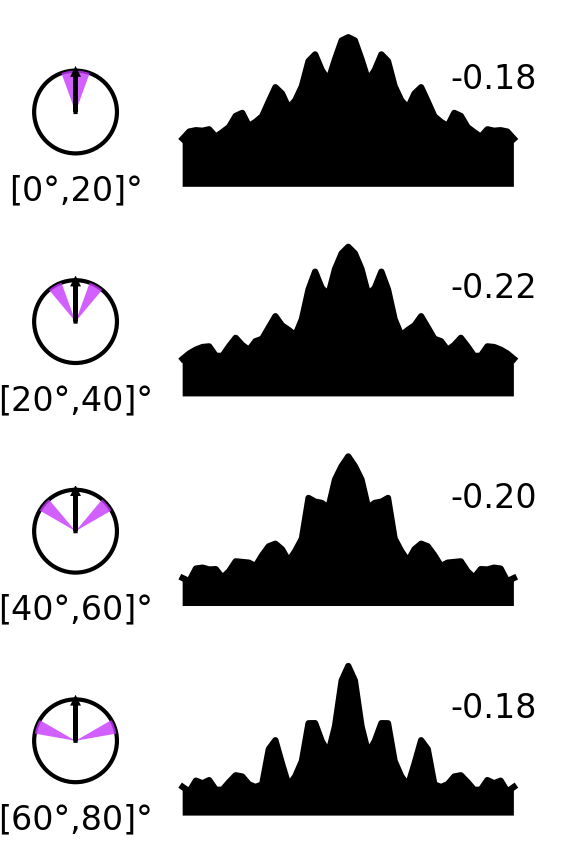

In [11]:
all_autocorrelograms = []
for i in range(len(correlogram_nonskipcells_bins)):
    cell_autocorrelograms_bins = correlogram_nonskipcells_bins[i]
    # dict to array
    cell_autocorrelograms_bins = np.array([cell_autocorrelograms_bins[j] for j in range(config['anglebins'])])
    all_autocorrelograms.append(cell_autocorrelograms_bins)
#to array
all_autocorrelograms = np.array(all_autocorrelograms)
#mena over the first axis
mean_autocorrelograms = np.nanmean(all_autocorrelograms, axis=0)

#plot in a 5*1 grid
fig = plt.figure(figsize=(2, 3), dpi=300)

labelsize = 10
ticksize = 8
gs = fig.add_gridspec(config['anglebins'], 2, width_ratios=[1, 4])



angle = config['angle_range']
for i in range(config['anglebins']):
    ax = fig.add_subplot(gs[i, 1])
    plot_autocorrelogram(ax, mean_autocorrelograms[i], cell_type=f'offset angle {(i+1)*angle}°', labelsize=labelsize, ticksize=ticksize)
    ax.set_title('')
    #add text as f'offset angle {(i+1)*angle}°'
    ax.text(0.9, 0.7, f'{mean_TS_noskip[i]:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=ticksize)
    if i < config['anglebins'] - 0:
        ax.set_xticks([])
        ax.set_xlabel('')
    # ax.set_xlabel(r'$\theta$-skipping index' + f'{mean_TS[i]:.2f}', fontsize=labelsize)

for i in range(config['anglebins']):
    ax = fig.add_subplot(gs[i, 0])
    plot_colored_wheel(ax, [angle * i, angle * (i + 1)], color='#c738ff')
    ax.set_xlabel(f'[{i*angle}°,{(i+1)*angle}]°', fontsize=ticksize)
    
plt.tight_layout()

plt.savefig('./figures/theta_nonskipping_different_anglebins.pdf')

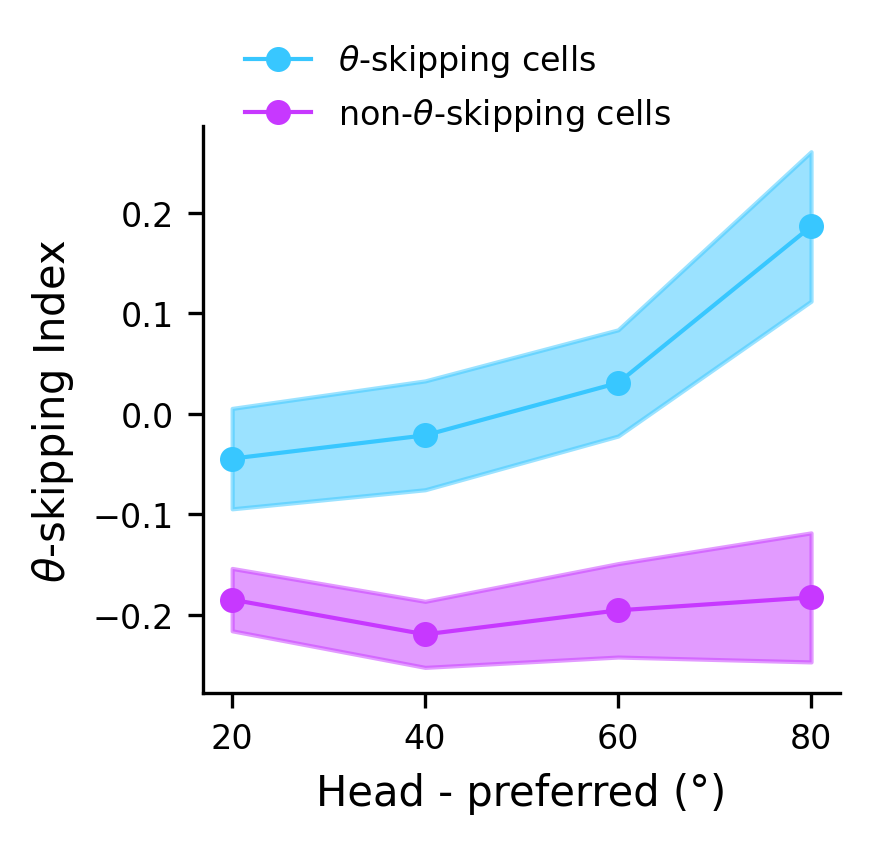

In [12]:
#plot mean_TS_skip and mean_TS_noskip in the same plot
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
labelsize = 10
ticksize = 8

angle = config['angle_range']
anglebins = config['anglebins']
x = np.arange(angle, (anglebins+1)*angle, angle)
ax.plot(x, mean_TS_skip, color='#38c7ff', marker='o', markersize=5, linewidth=1, label=r'$\theta$-skipping cells')
ax.plot(x, mean_TS_noskip, color='#c738ff', marker='o', markersize=5, linewidth=1, label=r'non-$\theta$-skipping cells')

ax.fill_between(x, mean_TS_skip - sem_TS_skip, mean_TS_skip + sem_TS_skip, color='#38c7ff', alpha=0.5)
ax.fill_between(x, mean_TS_noskip - sem_TS_noskip, mean_TS_noskip + sem_TS_noskip, color='#c738ff', alpha=0.5)

ax.set_xlabel('Head - preferred (°)', fontsize=labelsize)
ax.set_ylabel(r'$\theta$-skipping Index', fontsize=labelsize)
ax.tick_params(axis='both', which='major', labelsize=ticksize)

ax.legend(fontsize=ticksize, frameon=False, bbox_to_anchor=(0.4, 1.2), loc='upper center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/theta_skipping_index_compare.pdf')


### check correlation between skipping index and tuning width

In [13]:
base_dir = '/home/zilong/Desktop/GridCellThetaSweeps/LomiData/'

# Configuration
config = {
    'interpolation_factor': 2, #1 is 0.02s, and 2 is 0.01s
}

total_hd_cells = 0

tune_width_theta_cells = []
tune_width_skip_cells = []
tune_width_nonskip_cells = []
skipindex_theta_cells = []
skipindex_skip_cells = []
skipindex_nonskip_cells = []
autocorrelogram_theta_cells = []

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        cell_type = cell_data['cell_type']
                        
                        if pval < 0.05:  # select only head direction tuned cells
                            # save fig according to cell type in different folders

                            try:                              
                                
                                if 'ThetaxHD' in cell_type:
                                    
                                    # spike_array = compute_spike_array(pspt, pot_interp)
                                    # autocorrelogram = compute_autocorrelation(spike_array, bin_size=new_interval, max_lag=0.5) 
                                    
                                        # skip_index = calculate_skipping_index(autocorrelogram)[1]
                                        # skipindex_theta_cells.append(skip_index)
                                        # tune_width_theta_cells.append(tune_width)
                                        # autocorrelogram_theta_cells.append(autocorrelogram)
                                    spike_array = compute_spike_array(pspt, pot_interp)
                                    autocorrelogram = compute_autocorrelation(spike_array, bin_size=new_interval, max_lag=0.5) 
                                    skip_index = calculate_skipping_index(autocorrelogram)[1]
                                    skipindex_theta_cells.append(skip_index)
                                    tune_width_theta_cells.append(tune_width)
                                    autocorrelogram_theta_cells.append(autocorrelogram)       
                                    
                                    if 'skip' in cell_type:
                                        skipindex_skip_cells.append(skip_index)
                                        tune_width_skip_cells.append(tune_width)
                                    elif 'Strong ThetaxHD' in cell_type:
                                        skipindex_nonskip_cells.append(skip_index)
                                        tune_width_nonskip_cells.append(tune_width)            
                            except:
                                pass

                            
                            total_hd_cells += 1
                        
print(f"Total number of HD cells processed: {total_hd_cells}")

Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_100919_T1_sdata.mat
Intrinsic Theta Frequency: 8.20 Hz
Theta Cycle Skipping Index: -0.07
Intrinsic Theta Frequency: 8.83 Hz
Theta Cycle Skipping Index: -0.08
Intrinsic Theta Frequency: 7.51 Hz
Theta Cycle Skipping Index: -0.14
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_090819_T1_sdata.mat
Intrinsic Theta Frequency: 8.62 Hz
Theta Cycle Skipping Index: -0.08
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Deskto

Pearson correlation coefficient: 0.41, p-value: 0.0000
Pearson correlation coefficient: -0.53, p-value: 0.0033
Pearson correlation coefficient: 0.47, p-value: 0.0014


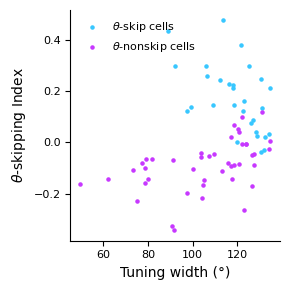

In [14]:
#scatter plot between tune_width and skipindex_theta_cells
fig, ax = plt.subplots(figsize=(3, 3))
labelsize = 10
ticksize = 8

# ax.scatter(tune_width_theta_cells, skipindex_theta_cells, s=5, color='black')
ax.scatter(tune_width_skip_cells, skipindex_skip_cells, s=5, color='#38c7ff', label=r'$\theta$-skip cells')
ax.scatter(tune_width_nonskip_cells, skipindex_nonskip_cells, s=5, color='#c738ff', label=r'$\theta$-nonskip cells')

ax.set_xlabel('Tuning width (°)', fontsize=labelsize)
ax.set_ylabel(r'$\theta$-skipping Index', fontsize=labelsize)
ax.tick_params(axis='both', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=ticksize, frameon=False)

#correlation test
r, p = pearsonr(tune_width_theta_cells, skipindex_theta_cells)
print(f"Pearson correlation coefficient: {r:.2f}, p-value: {p:.4f}")

r, p = pearsonr(tune_width_skip_cells, skipindex_skip_cells)
print(f"Pearson correlation coefficient: {r:.2f}, p-value: {p:.4f}")

r, p = pearsonr(tune_width_nonskip_cells, skipindex_nonskip_cells)
print(f"Pearson correlation coefficient: {r:.2f}, p-value: {p:.4f}")

plt.tight_layout()


Pearson correlation coefficient: 0.41, p-value: 1.5373264976094848e-05


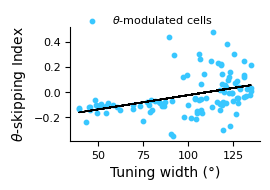

In [15]:
#scatter plot between tune_width and skipindex_theta_cells
fig, ax = plt.subplots(figsize=(2.8, 2.1))
labelsize = 10
ticksize = 8

# ax.scatter(tune_width_theta_cells, skipindex_theta_cells, s=5, color='black')
ax.scatter(tune_width_theta_cells, skipindex_theta_cells, s=10, color='#38c7ff', label=r'$\theta$-modulated cells')

ax.set_xlabel('Tuning width (°)', fontsize=labelsize)
ax.set_ylabel(r'$\theta$-skipping Index', fontsize=labelsize)
ax.tick_params(axis='both', which='major', labelsize=ticksize)

#add linear fitting line with a polynomial of degree 1
z = np.polyfit(tune_width_theta_cells, skipindex_theta_cells, 1)
p = np.poly1d(z)
ax.plot(tune_width_theta_cells, p(tune_width_theta_cells), color='black', linestyle='--', linewidth=1)

#correlation test
r, p = pearsonr(tune_width_theta_cells, skipindex_theta_cells)
print(f"Pearson correlation coefficient: {r:.2f}, p-value: {p}")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=ticksize, frameon=False, bbox_to_anchor=(0.4, 1.2), loc='upper center')

plt.tight_layout()

plt.savefig('./figures/tune_width_vs_theta_skipping_index.pdf')

#### plot all auto correlogram with the first has the highest theta skip index

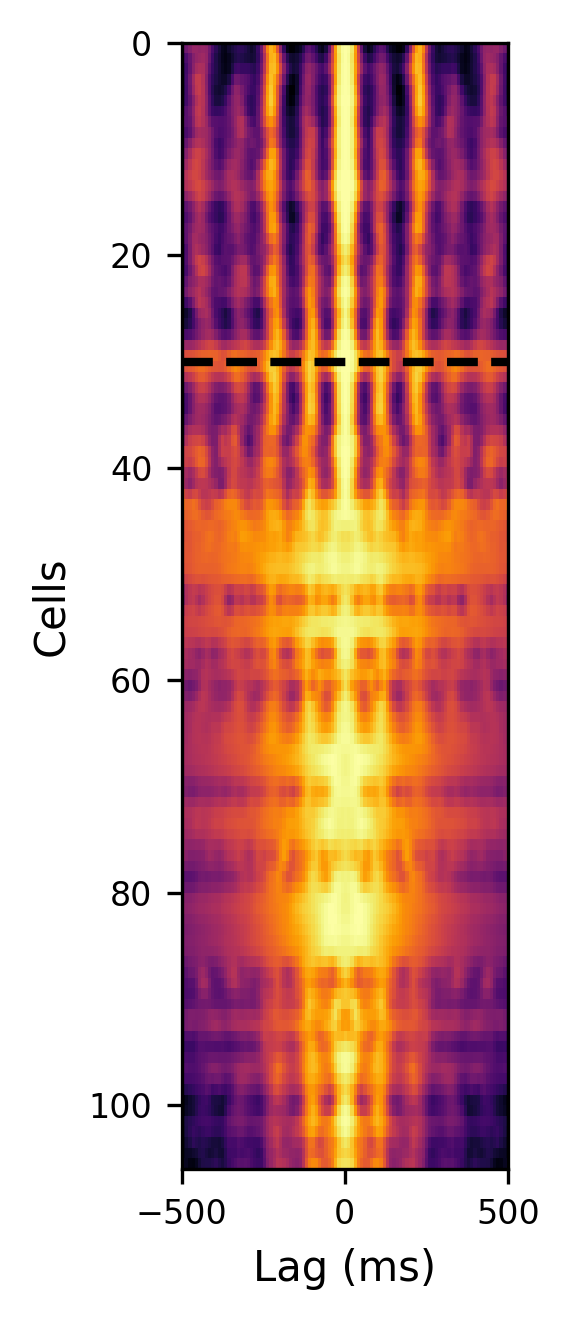

In [16]:
import scipy.ndimage as ndimage

autocorrelogram_theta_cells = np.array(autocorrelogram_theta_cells)
autocorrelogram_all = autocorrelogram_theta_cells[:,0,:]
#sort autocorrelogram_all according to skipindex_theta_cells from high to low
sorted_indices = np.argsort(skipindex_theta_cells)[::-1]
autocorrelogram_all = autocorrelogram_all[sorted_indices]

# Smooth the autocorrelogram with a Gaussian kernel
smoothed_autocorrelogram = ndimage.gaussian_filter(autocorrelogram_all, sigma=1)

#imshow smoothed_autocorrelogram
fig, ax = plt.subplots(figsize=(2.0, 4.5), dpi=300)
labelsize = 10
ticksize = 8

cmap = plt.get_cmap('inferno')
cmap.set_bad(color='white')
cmap.set_over(color='white')

im = ax.imshow(smoothed_autocorrelogram, cmap=cmap, aspect='auto', origin='upper', interpolation='none', extent=[-500, 500, len(smoothed_autocorrelogram), 0])

ax.set_xlabel('Lag (ms)', fontsize=labelsize)
ax.set_ylabel('Cells', fontsize=labelsize)
ax.set_xticks([-500, 0, 500])
#add another text on the right called 'increasing theta skipping index' with ticksize, show in vertick
# ax.text(1.1, 0.5, 'increasing theta skipping index', ha='center', va='center', fontsize=ticksize, transform=ax.transAxes, rotation=90)

#add y=70 dashed line as a reference
ax.axhline(y=30, color='black', linestyle='--', linewidth=2.0)


#ticksize 
ax.tick_params(axis='both', which='major', labelsize=ticksize)

plt.tight_layout()

plt.savefig('./figures/autocorr_theta_cells_sorted.pdf')
